In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datajoint as dj
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set_style('ticks')

import os
import sys
import inspect

p = !pwd
p = os.path.dirname(os.path.dirname(p[0]))
if p not in sys.path:
    sys.path.append(p)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from cnn_sys_ident.mesonet.parameters import Fit, Model, Core, Readout, RegPath
from cnn_sys_ident.mesonet.data import MultiDataset
from cnn_sys_ident.mesonet import MODELS

Connecting aecker@52.202.15.166:3306


# Get best model

In [3]:
num_filters = 16
num_rotations = 8
data_key = dict(data_hash='cfcd208495d565ef66e7dff9f98764da')
model_rel = MODELS['HermiteSparse'] * MultiDataset() & data_key \
    & 'positive_feature_weights=False AND shared_biases=False' \
    & {'num_filters_2': num_filters}
print(len(Fit() * model_rel))
key = (Fit() * model_rel).fetch(dj.key, order_by='val_loss', limit=1)[0]
model = Fit().load_model(key)

32
INFO:tensorflow:Restoring parameters from /gpfs01/bethge/home/aecker/home/lab/projects/microns/cnn-sys-ident-iclr/checkpoints/aecker_mesonet_data/647bb1d1bd02979996e492b5422eb95f/model.ckpt


# Distribution of non-zero weights for all features

In [4]:
w = model.base.evaluate(model.readout.feature_weights)
ww = w.reshape([-1, num_rotations, num_filters])
print(w.shape)

(6005, 128)


[0.74485861 0.75723473 0.76508708 0.77440633 0.79226146 0.86353879
 0.90155865 0.90972222 0.91310582 0.91603269 0.92562814 0.93979933
 0.95594866 0.96709957 0.96811308 0.97165669]


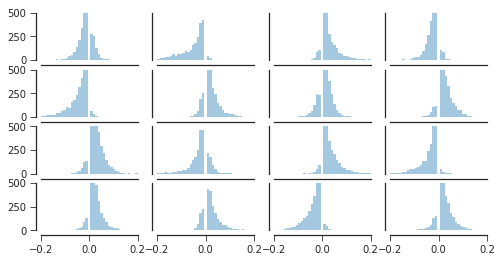

In [5]:
p = 0.01
n = int(np.ceil(np.sqrt(num_filters)))
m = int(np.ceil(num_filters / n))
frac = []
fig, axes = plt.subplots(m, n, figsize=(2*n, m))
for i, ax in zip(range(num_filters), axes.flatten()):
    wi = w[:,i::num_filters].flatten()
    idx = np.abs(wi) > p
    frac.append((wi > p).sum() / idx.sum())
    sns.distplot(wi[idx], bins=np.linspace(-0.2, 0.2, 40), ax=ax, kde=False)
    ax.set_xlim([-0.2, 0.2])
    ax.set_ylim([0, 500])
    sns.despine(offset=5)
    if i < (m-1)*n:
        ax.set_xticks([])
    if i not in range(0, m*n, n):
        ax.set_yticks([])
fig.savefig('figures/feature_weights_distr.eps', format='eps')

frac = np.array(frac)
frac = np.maximum(frac, 1-frac)
print(np.sort(frac))

# Number of features capturing more than 5% of variance

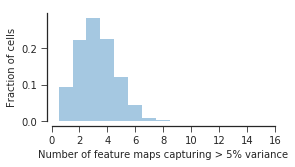

In [6]:
p = 0.05
w_norm = w / np.sqrt(np.sum(w ** 2, axis=1, keepdims=True))
w_marg = w_norm.reshape([-1, num_rotations, num_filters])
w_marg = np.sum(w_marg ** 2, axis=1)
active = (w_marg > p).sum(axis=1)

plt.figure(figsize=(4, 2))
sns.distplot(active, bins=np.arange(16)+0.5, kde=False, norm_hist=True)
plt.xlabel('Number of feature maps capturing > 5% variance')
plt.ylabel('Fraction of cells')
plt.xlim([0, 16])
plt.xticks(range(0, 17, 2))
sns.despine(offset=5)
plt.savefig('figures/feature_weights_sparse.eps', format='eps')
plt.show()

### 'Clean' cells where the major feature captures at least 50% of the variance

In [7]:
q = 0.5
clean = w_marg.max(axis=1) > q
clean.mean()

0.6196502914238134

# Plot feature weights

In [8]:
type_id = np.argmax(np.abs(w_marg), axis=1)
counts, _ = np.histogram(type_id, range(num_filters+1))
n = counts.max()

### Unsorted

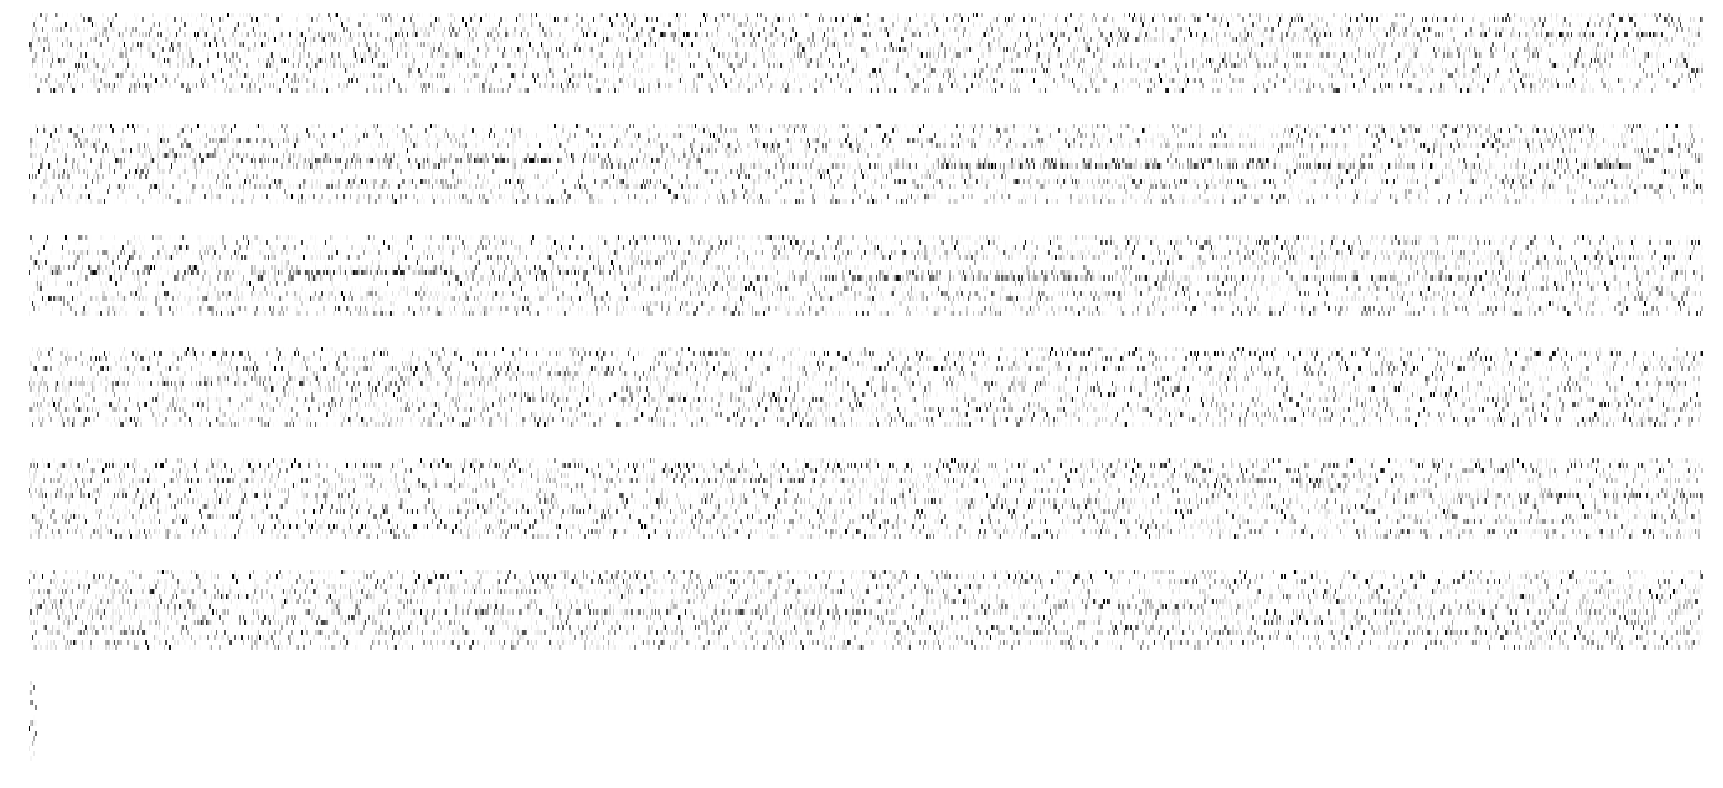

In [9]:
per_row = 1000
num_cells = type_id.shape[0]
num_rows = int(np.ceil(num_cells / per_row))
fig, axes = plt.subplots(num_rows, 1, figsize=(30, 2000/per_row*num_rows))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(1 - w_marg[i*per_row:(i+1)*per_row].T, cmap='gray', aspect=3)
    ax.set_xlim((0, per_row))
    ax.axis('off')

fig.savefig('figures/feature_weights_unsorted.eps', format='eps')

### Sorted by weights

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  del sys.path[0]


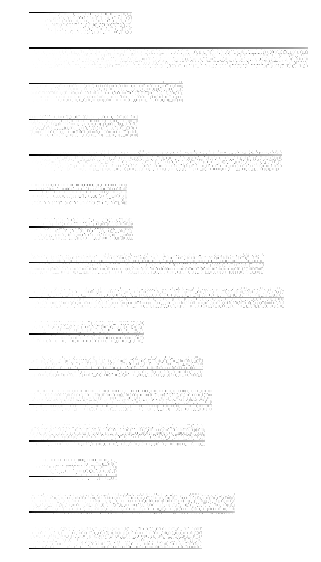

In [10]:
import scipy.misc

fig, axes = plt.subplots(num_filters, 1, figsize=(5, 10))
for i, ax in zip(range(num_filters), axes.flatten()):
    idx = (type_id == i)
    wi = w_marg[idx]
    order = np.argsort(-wi[:,i])
    ax.imshow(1 - wi[order].T, vmin=0, vmax=1, cmap='gray', aspect=3)
    ax.set_xticks([])
    ax.set_xlim([0, n])
    ax.axis('off')
    
    scipy.misc.toimage(1 - wi[order].T, cmin=0.0, cmax=1).save(
        'figures/feature_weights_{:d}.png'.format(i))
    
fig.savefig('figures/feature_weights.eps', format='eps')

# Control model with dense feature weights (L2 regularized)

In [11]:
num_filters = 16
num_rotations = 8
data_key = dict(data_hash='cfcd208495d565ef66e7dff9f98764da')
model_rel = MODELS['HermiteDenseSeparate'] * MultiDataset() & data_key \
    & 'positive_feature_weights=False AND shared_biases=False' \
    & {'num_filters_2': num_filters}
print(len(Fit() * model_rel))
key_2 = (Fit() * model_rel).fetch(dj.key, order_by='val_loss', limit=1)[0]
model_2 = Fit().load_model(key_2)

32
INFO:tensorflow:Restoring parameters from /gpfs01/bethge/home/aecker/home/lab/projects/microns/cnn-sys-ident-iclr/checkpoints/aecker_mesonet_data/9ef7308edab3233c4d02d280ea37bc93/model.ckpt


In [12]:
w_2 = model_2.base.evaluate(model_2.readout.feature_weights)
ww_2 = w_2.reshape([-1, num_rotations, num_filters])
print(w_2.shape)

(6005, 128)


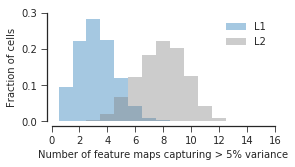

In [13]:
p = 0.05
w_norm_2 = w_2 / np.sqrt(np.sum(w_2 ** 2, axis=1, keepdims=True))
w_marg_2 = w_norm_2.reshape([-1, num_rotations, num_filters])
w_marg_2 = np.sum(w_marg_2 ** 2, axis=1)
active_2 = (w_marg_2 > p).sum(axis=1)

plt.figure(figsize=(4, 2))
sns.distplot(active, bins=np.arange(16)+0.5, kde=False, norm_hist=True)
sns.distplot(active_2, bins=np.arange(16)+0.5, kde=False, norm_hist=True, color=(0.5, 0.5, 0.5))
plt.xlabel('Number of feature maps capturing > 5% variance')
plt.ylabel('Fraction of cells')
plt.xlim([0, 16])
plt.ylim([0, 0.3])
plt.xticks(range(0, 17, 2))
plt.legend(['L1', 'L2'])
sns.despine(offset=5)
plt.savefig('figures/feature_weights_sparse.eps', format='eps')
plt.show()

[0.50539296 0.50747594 0.52447694 0.5572847  0.55849997 0.5657764
 0.5809565  0.60520996 0.63472323 0.63823588 0.66624982 0.78767617
 0.81479953 0.84619811 0.86986264 0.89014796]


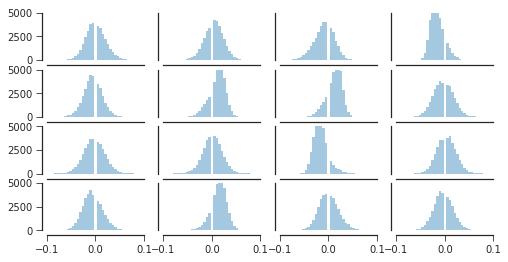

In [14]:
p = 0.003
n = int(np.ceil(np.sqrt(num_filters)))
m = int(np.ceil(num_filters / n))
frac = []
fig, axes = plt.subplots(m, n, figsize=(2*n, m))
for i, ax in zip(range(num_filters), axes.flatten()):
    wi = w_2[:,i::num_filters].flatten()
    idx = np.abs(wi) > p
    frac.append((wi > p).sum() / idx.sum())
    sns.distplot(wi[idx], bins=np.linspace(-0.1, 0.1, 40), ax=ax, kde=False)
    ax.set_xlim([-0.1, 0.1])
    ax.set_ylim([0, 5000])
    sns.despine(offset=5)
    if i < (m-1)*n:
        ax.set_xticks([])
    if i not in range(0, m*n, n):
        ax.set_yticks([])
fig.savefig('figures/feature_weights_distr.eps', format='eps')

frac = np.array(frac)
frac = np.maximum(frac, 1-frac)
print(np.sort(frac))